In [ ]:
# !pip install tensorflow==2.10.0

# !pip install pandas-datareader==0.10.0

In [2]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader
import datetime

from tqdm import tqdm_notebook, tqdm
from collections import deque

In [3]:
print(data_reader.__version__)
print(tf.__version__)

0.10.0
2.10.0


In [4]:
class AI_Trader():
  
    def __init__(self, state_size, action_space=3, model_name="AITrader"):

        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen = 2000)
        self.inventory = []
        self.model = self.model_builder()
        self.model_name = self.model.name

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
  
    def model_builder(self):

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer="Adam")
        return model

    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        print("act_values: ",act_values)
        return np.argmax(act_values[0])
    
    def batch_train(self, batch_size):

        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            batch.append(self.memory[i])

        for state, action, reward, next_state, done in batch:
            target = self.model.predict(state)

        if not done:
            target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target[0][action] = reward

        self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

In [5]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def stocks_price_format(n):
    if n < 0:
        return "- $ {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

def dataset_loader(stock_name):

    dataset = data_reader.DataReader(stock_name, data_source="yahoo")

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[-1]).split()[0]

    close = dataset['Close']
    print("시작일: {}, 종료일: {}".format(start_date, end_date))
    return close

def state_creator(data, timestep, window_size):
  
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1]
    else:
        windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
        
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))

    return np.array([state])

In [6]:
stock_name = "AAPL"
data = dataset_loader(stock_name).iloc[-50:]
data

시작일: 2017-11-17, 종료일: 2022-11-16


Date
2022-09-08    154.460007
2022-09-09    157.369995
2022-09-12    163.429993
2022-09-13    153.839996
2022-09-14    155.309998
2022-09-15    152.369995
2022-09-16    150.699997
2022-09-19    154.479996
2022-09-20    156.899994
2022-09-21    153.720001
2022-09-22    152.740005
2022-09-23    150.429993
2022-09-26    150.770004
2022-09-27    151.759995
2022-09-28    149.839996
2022-09-29    142.479996
2022-09-30    138.199997
2022-10-03    142.449997
2022-10-04    146.100006
2022-10-05    146.399994
2022-10-06    145.429993
2022-10-07    140.089996
2022-10-10    140.419998
2022-10-11    138.979996
2022-10-12    138.339996
2022-10-13    142.990005
2022-10-14    138.380005
2022-10-17    142.410004
2022-10-18    143.750000
2022-10-19    143.860001
2022-10-20    143.389999
2022-10-21    147.270004
2022-10-24    149.449997
2022-10-25    152.339996
2022-10-26    149.350006
2022-10-27    144.800003
2022-10-28    155.740005
2022-10-31    153.339996
2022-11-01    150.649994
2022-11-02    145.02

In [7]:
window_size = 5
episodes = 1
capital = 10000

batch_size = 8
data_samples = len(data) - 1

In [8]:
trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [9]:
assets = []
start_time = datetime.datetime.now()

for episode in range(1, episodes + 1):
  
    print("Episode: {}/{}".format(episode, episodes))

    state = state_creator(data, 10, window_size + 1)
    amount = [] # 거래량
    action = [0]
    cash = capital # 자본금
    trader.inventory = []
    sells = []
    buys = []
    closes = []
    asset = 0
    reward = 0
    tak_stocks=0 # 보유 주식 수량
    # for t in tqdm(range(data_samples)):
    for t in tqdm(range(window_size,data_samples)):
        closes.append(data[t])
        
        action = trader.trade(state)

        next_state = state_creator(data, t+1, window_size + 1)
        if action == 1 and cash > data[t]: #Buying
            stock = divmod(cash, data[t])
            reward += 100
            if stock[0]*0.3 > 1:
                num_stock = math.trunc(stock[0]*0.3)
                cash -= data[t]*float(num_stock)
                print("purchase price: {0:.2f} $, amount of purchase: {1}, cash: {2:.2f} $".format(data[t],num_stock,cash))
            
            else:
                num_stock = int(stock[0])
                cash -= data[t]*num_stock
                print("purchase price: {0:.2f} $, amount of purchase: {1}, cash: {2:.2f} $".format(data[t],num_stock,cash))
            
            trader.inventory.append((data[t],num_stock))
            amount.append(num_stock)
            tak_stocks += num_stock
            buys.append(data[t])
            sells.append(None)
            
          
        
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_stock = trader.inventory.pop(0)
            

            reward += max((data[t] - buy_stock[0])*buy_stock[1], 0)
            cash += data[t]*buy_stock[1]

            sells.append(data[t])
            buys.append(None)
            
            amount.append(buy_stock[1])
            tak_stocks -= buy_stock[1]
            print("selling price: {0:.2f} $, amount of selling: {1}, cash: {2:.2f} $".format(data[t],int(buy_stock[1]),cash))
            
        else:
            reward += 1
            buys.append(None)
            sells.append(None)
            amount.append(0)
        if t == data_samples - 1:
            done = True
        else:
            done = False
      
        trader.memory.append((state, action, reward, next_state, done))

        state = next_state

        if done:
            if len(trader.inventory) == 0:
                print("########################")
                print("TOTAL ASSET: {:.2f} $".format(cash))
                print("########################")
                assets.append(cash)
            else:
                num_stocks = 0
                for a in trader.inventory:
                    num_stocks += a[1]
                asset = num_stocks * data[-1] + cash
                print("########################")
                print("TOTAL ASSET: {:.2f} $".format(asset))
                print("########################")
                assets.append(asset)  
        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)
      
    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))
end_time = datetime.datetime.now()
print("총 소요 시간: {}".format(end_time - start_time))

Episode: 1/1


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

purchase price: 151.76 $, amount of purchase: 19, cash: 7116.56 $
1/1 [==============================] - 0s 71ms/step


 20%|████████████████▉                                                                  | 9/44 [00:03<00:13,  2.63it/s]

selling price: 149.84 $, amount of selling: 19, cash: 9963.52 $
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:04<00:17,  1.91it/s]

1/1 [==============================] - 0s 80ms/step


 25%|████████████████████▌                                                             | 11/44 [00:06<00:23,  1.39it/s]

purchase price: 138.20 $, amount of purchase: 21, cash: 7061.32 $
1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:08<00:28,  1.10it/s]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:31,  1.03s/it]

selling price: 146.10 $, amount of selling: 21, cash: 10129.42 $
1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:33,  1.12s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:35,  1.22s/it]

1/1 [==============================] - 0s 54ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:14<00:36,  1.30s/it]

1/1 [==============================] - 0s 56ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:17<00:46,  1.70s/it]

1/1 [==============================] - 0s 62ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:19<00:49,  1.89s/it]

purchase price: 138.98 $, amount of purchase: 21, cash: 7210.84 $
1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:21<00:46,  1.88s/it]

1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:22<00:42,  1.76s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:24<00:42,  1.83s/it]

purchase price: 138.38 $, amount of purchase: 15, cash: 5135.14 $
1/1 [==============================] - 0s 70ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:26<00:38,  1.74s/it]

purchase price: 142.41 $, amount of purchase: 10, cash: 3711.04 $
1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:27<00:34,  1.66s/it]

selling price: 143.75 $, amount of selling: 21, cash: 6729.79 $
1/1 [==============================] - 0s 51ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:29<00:32,  1.60s/it]

purchase price: 143.86 $, amount of purchase: 13, cash: 4859.61 $
1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:30<00:30,  1.60s/it]

selling price: 143.39 $, amount of selling: 15, cash: 7010.46 $
1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:32<00:29,  1.62s/it]

purchase price: 147.27 $, amount of purchase: 14, cash: 4948.68 $
1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:33<00:27,  1.61s/it]

1/1 [==============================] - 0s 64ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:35<00:26,  1.64s/it]

purchase price: 152.34 $, amount of purchase: 9, cash: 3577.62 $
1/1 [==============================] - 0s 52ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:37<00:23,  1.60s/it]

purchase price: 149.35 $, amount of purchase: 6, cash: 2681.52 $
1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:38<00:22,  1.59s/it]

selling price: 144.80 $, amount of selling: 10, cash: 4129.52 $
1/1 [==============================] - 0s 56ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:40<00:21,  1.62s/it]

1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:41<00:19,  1.58s/it]

selling price: 153.34 $, amount of selling: 13, cash: 6122.94 $
1/1 [==============================] - 0s 51ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:43<00:17,  1.58s/it]

selling price: 150.65 $, amount of selling: 14, cash: 8232.04 $
1/1 [==============================] - 0s 57ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:45<00:15,  1.60s/it]

1/1 [==============================] - 0s 81ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:46<00:14,  1.62s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:48<00:13,  1.72s/it]

1/1 [==============================] - 0s 49ms/step
act_values:  [[0.3826483  0.28232336 0.33823147]]
1/1 [==============================] - 0s 55ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:50<00:12,  1.81s/it]

1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:52<00:10,  1.77s/it]

selling price: 139.50 $, amount of selling: 9, cash: 9487.54 $
1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:53<00:08,  1.68s/it]

1/1 [==============================] - 0s 40ms/step
act_values:  [[0.69593024 0.521279   0.67190933]]
1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:55<00:06,  1.65s/it]

1/1 [==============================] - 0s 63ms/step
act_values:  [[1.2831391 0.8246194 1.1119078]]
1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:57<00:05,  1.68s/it]

1/1 [==============================] - 0s 72ms/step
act_values:  [[1.9793818 1.2914696 1.5661525]]
1/1 [==============================] - 0s 61ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:59<00:03,  1.90s/it]

selling price: 148.28 $, amount of selling: 6, cash: 10377.22 $
1/1 [==============================] - 0s 69ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:01<00:01,  1.98s/it]

########################
TOTAL ASSET: 10377.22 $
########################
1/1 [==============================] - 0s 55ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:03<00:00,  1.45s/it]

총 소요 시간: 0:01:03.638480


In [13]:
print(assets)

[10377.220016479492]


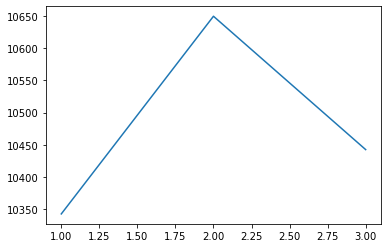

In [32]:
x = np.arange(1,len(assets)+1)
y = assets
plt.plot(x,y)
plt.show()

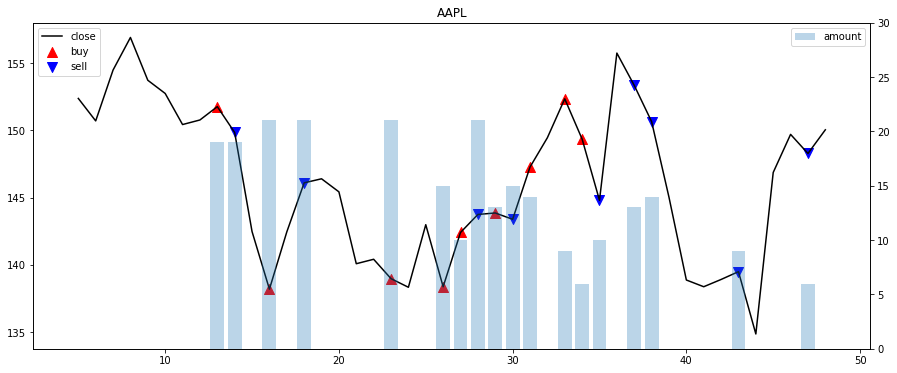

In [12]:
x_data = range(window_size,data_samples)

plt.figure(figsize=(15, 6))
plt.plot(x_data, closes,color="black")
plt.scatter(x_data, buys, marker='^',color='r',s=100)
plt.scatter(x_data, sells, marker='v',color='b',s=100)
plt.legend(['close', 'buy', 'sell'],loc=2 )

y_right = plt.twinx()
y_right.bar(x_data, amount,alpha =0.3)
# y_right.xticks(x_data,)
plt.ylim(0, 30)
plt.title(stock_name)
plt.legend(['amount'], loc=1)
plt.show()

In [ ]:
# state_size =5
# action_space = 3
# state = state_creator(data, 10, window_size + 1)
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=state_size))
# model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.Dense(units=action_space, activation='linear'))
# model.compile(loss='mse', optimizer="Adam")
# act_values = model.predict(state)
# print(act_values)
# print(state)